# Imports

In [ ]:
import json

from flashtext2 import KeywordProcessor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymongo import MongoClient
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
)

In [2]:
torch.cuda.is_available()

True

# Data Preprocessing

In [3]:
client = MongoClient("mongodb://localhost:27017")
coll = client.get_database("fakenews").get_collection("articles")

In [9]:
# Get English or German Articles
language = "en"
df = pd.DataFrame(list(coll.find({"language": language})))

In [10]:
# Remap label to numeric for training
id2label = {0: "fake", 1: "real"}
label2id = {"fake": 0, "real": 1}
df["label"] = df["label"].map(label2id)

In [11]:
# Combine Title and Text
df["content"] = df["title"] + " [SEP] " + df["text"]
# Remove duplicates and missing values
df = df.copy().dropna(subset=["content", "label"]).drop_duplicates(subset=["content"])
# Clean formatting errors
df["content"] = (
    df["content"]
    .str.replace("Ã¤", "ä", regex=True)
    .replace("Ã¼", "ü", regex=True)
    .replace("Ã¶", "ö", regex=True)
    .replace("kã", "kä", regex=True)
    .replace("fã¼r", "für", regex=True)
)

In [12]:
# Balance dataset by undersampling
df["label"] = df["label"].astype(int)
df = df.groupby("label").sample(df.groupby("label").size().min())

# Baseline Model to identify the most important words
The primary objective for using this baseline model is to try and prevent data leakage.
By identifying and removing specific words or meta topics, which the model might use to shortcut the learning process, it prevents the model from focussing on the specific format of this dataset and rather focus on the nature of misinformation.

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(df["content"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

print(f"Baseline Accuracy: {clf.score(X_test, y_test):.4f}")

In [ ]:
# Calucalate coefficients
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]

# Sort and print Top 20 words for each label
top_positive = np.argsort(coefs)[-20:]
top_negative = np.argsort(coefs)[:20]

print("Real")
print([feature_names[j] for j in top_positive])

print("\nFake")
print([feature_names[j] for j in top_negative])

## Remove German Keywords

In [ ]:
forbidden_sources = [
    "kenfm",
    "rubikon",
    "compact",
    "qs24",
    "connectiv",
    "rt deutsch",
    "sciencefiles",
    "spürnase",
    "bildplus",
    "ippen",
    "dpa",
    "reuters",
    "heise",
    "rt",
    "dts",
    "btz",
    "kurier",
    "pixabay",
    "kitzingen",
    "kissingen",
    "ebersberg",
    "main-post",
    "getty",
    "imago",
    "wochit",
    "picture",
    "symbolbild",
    "dpa",
    "connectiv",
    "dumont",
    "larsen",
    "petersen",
    "burkhard",
    "faeser",
]

forbidden_ui = [
    "newsletter",
    "newslettern",
    "interagieren",
    "kostenlos",
    "abonniere",
    "bestellen",
    "like",
    "follow",
    "klick",
    "runderneuerte",
    "detailansicht",
    "bildunterschrift",
    "quelle",
    "siehe",
    "anmerkungen",
    "auszug",
    "download",
    "anzeige",
    "images",
    "inhalt",
    "javascript",
    "drittplattformen",
    "none",
    "surftipp",
    "herunterladen",
    "korrespondent",
    "mehr zum thema",
    "ausblenden",
    "weiterleiten",
    "empfohlener",
    "ticker",
    "personenbezogene",
    "lesen",
    "wall",
    "ap",
    "alliance",
    "datenschutzerklärung",
    "tweeten",
    "034",
    "mitteilt",
    "empfehlen",
    "unterstützungsmöglichkeiten",
]

forbidden_names = [
    "winogradow",
    "tschebyachkinchoy",
    "lefebvre",
    "semjonow",
    "bogdanow",
    "soerensen",
    "pchartschoy",
    "wassiljew",
    "fjodorow",
    "fournier",
    "lebedew",
    "joergensen",
    "solowjow",
    "sokolow",
    "karlsson",
    "nilsson",
    "petrow",
    "rousseau",
    "walsh",
    "rasmussen",
    "alexej",
]

forbidden_local_news = [
    "schweinfurt",
    "rhön",
    "polizeiinspektion",
    "gemeinderat",
    "kommunalwahl",
    "sonnabend",
    "lokaler",
    "präsidentenwahl",
]

all_forbidden = (
    forbidden_sources + forbidden_ui + forbidden_names + forbidden_local_news
)

kp = KeywordProcessor(case_sensitive=False)

for word in all_forbidden:
    kp.add_keyword(word, "")

cleaned_content = [kp.replace_keywords(text) for text in df["content"].tolist()]

df["content"] = cleaned_content

## Remove English Keywords

In [13]:
df = df.dropna(subset=["content"])
df["content"] = df["content"].astype(str)


regexes = [
    r"http\S*|www\.\S*|https\S*",
    r"pic.twitter.com\*+",
    r"bit.ly\S*",
    r"21wire\S*",
    r"\S*\.via\S*",
    r"\S*:via\S*",
    r"\S*\.com\S*",
    r"\S*@\S*",
    r".Featured.*",
]

for rx in regexes:
    df["content"] = df["content"].str.replace(rx, " ", regex=True, case=False)


forbidden_meta = [
    "nan",
    "ian",
    "marlow",
    "pollak",
    "hawkins",
    "pam",
    "pamkeynen",
    "jerome",
    "corrects",
    "regrets",
    "associate",
    "covering",
    "columnist",
    "contributor",
    "factbox",
    "weekdays",
    "03",
    "201",
    "edited",
    "paragraph",
]

forbidden_sources = [
    "reuters",
    "breitbart",
    "ap",
    "associated press",
    "siriusxm",
    "twitter",
    "getty",
    "flickr",
    "nyt",
    "new york times",
    "fox news",
    "cnn",
    "bbc",
    "factbox",
    "sirius",
    "daily caller",
    "caller",
    "rohingya",
    "cartel",
    "daesh",
    "sputnik",
    "youtube",
    "facebook",
    "rt",
    "afp",
    "wire",
    "permission",
    "broadcast",
    "excerpts",
    "com",
    "21wire",
    "21wire.tv",
    "twittervia",
    "viacom",
    "2017the",
    "napolitano",
]

forbidden_ui = [
    "via",
    "featured",
    "read",
    "breaking",
    "snip",
    "pic",
    "photo",
    "image",
    "video",
    "swipe",
    "print",
    "tags",
    "category",
    "follow",
    "share",
    "click",
    "subscribe",
    "advertisement",
    "copyright",
    "com",
    "http",
    "https",
    "ly",
    "bit",
    "html",
    "php",
    "ly",
    "com",
    "co",
    "youtu",
    "nan",
    "http",
    "https",
    "www",
    "screenshot",
    "jpg",
    "png",
]

forbidden_dates = [
    "monday",
    "tuesday",
    "wednesday",
    "thursday",
    "friday",
    "saturday",
    "sunday",
    "january",
    "february",
    "march",
    "april",
    "may",
    "june",
    "july",
    "august",
    "september",
    "october",
    "november",
    "december",
    "2016",
    "2017",
    "2018",
    "2019",
    "2020",
    "2021",
    "2022",
    "2023",
    "2024",
    "2025",
    "decade",
]

forbidden_topics = [
    "mugabe",
    "libyan",
    "jerome",
    "powell",
    "trump",
    "clinton",
    "obama",
    "milo",
    "catalonia",
    "basket",
]

all_forbidden = (
    forbidden_meta
    + forbidden_sources
    + forbidden_ui
    + forbidden_dates
    + forbidden_topics
)

kp = KeywordProcessor(case_sensitive=False)

for word in all_forbidden:
    kp.add_keyword(word, "")

cleaned_content = [kp.replace_keywords(text) for text in df["content"].tolist()]

df["content"] = cleaned_content

# Training the model

In [14]:
train, houldout_test = train_test_split(
    df, test_size=0.2, random_state=141, stratify=df["label"]
)

In [15]:
# Prepare Training and validation Datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train["content"].tolist(),
    train["label"].tolist(),
    test_size=0.1,
    random_state=141,
    stratify=train["label"],
)

In [16]:
if language == "en":
    bert_identifier = "distilbert-base-cased"
elif language == "de":
    bert_identifier = "distilbert-base-german-cased"
else:
    bert_identifier = "distilbert-base-multilingual-cased "

tokenizer = DistilBertTokenizer.from_pretrained(bert_identifier)

model = DistilBertForSequenceClassification.from_pretrained(
    bert_identifier, num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Use the maximum length possible for news articles
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [18]:
# Setup dataset
class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

In [20]:
# Define metrics for validation while training
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(y_true=labels, y_pred=predictions)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=labels, y_pred=predictions, average="weighted"
    )

    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

In [21]:
# Paramaters might need tuning for the language and size of the dataset used
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="no",
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    report_to="tensorboard",
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.098000,0.073663,0.978411,0.978409,0.978541,0.978411
1000,0.044100,0.047979,0.986201,0.986201,0.986220,0.986201
1500,0.022700,0.042524,0.989094,0.989094,0.989116,0.989094
2000,0.019600,0.028913,0.991988,0.991988,0.991989,0.991988
2500,0.014700,0.029201,0.992210,0.992210,0.992211,0.992210


TrainOutput(global_step=2528, training_loss=0.08158758737712721, metrics={'train_runtime': 358.1474, 'train_samples_per_second': 225.806, 'train_steps_per_second': 7.059, 'total_flos': 1.0712903464108032e+16, 'train_loss': 0.08158758737712721, 'epoch': 2.0})

In [24]:
model_path = f"./models/fake_news_bert_model_{language}"
# Configure label mapping
trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

trainer.state.log_history

# Save training logs for later use
with open(f"{model_path}/train_logs.json", "w") as f:
    json.dump(trainer.state.log_history, f)

# Train/Val Loss

In [51]:
with open(f"./models/fake_news_bert_model_{language}/train_logs.json") as f:
    log_history = json.load(f)

df_logs = pd.DataFrame(log_history)

train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]].copy()
train_loss["type"] = "train"
train_loss.columns = ["step", "loss", "type"]

eval_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]].copy()
eval_loss["type"] = "validation"
eval_loss.columns = ["step", "loss", "type"]

plot_data = pd.concat([train_loss, eval_loss])

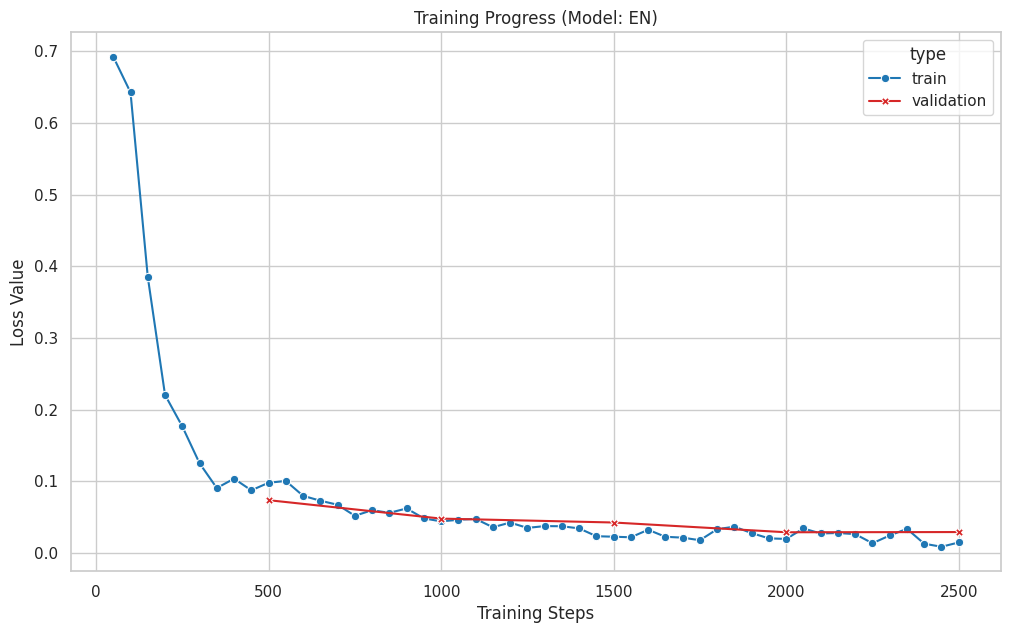

In [55]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

loss_plot = sns.lineplot(
    data=plot_data,
    x="step",
    y="loss",
    hue="type",
    style="type",
    markers=True,
    dashes=False,
    palette=["#1f77b4", "#d62728"],
)

plt.title(f"Training Progress (Model: {language.upper()})")
plt.xlabel("Training Steps")
plt.ylabel("Loss Value")

plt.show()

# Classification Report

In [67]:
# Load the trained model in a pipeline
pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    device=0,
    padding=True,
    truncation=True,
    max_length=512,
    batch_size=64,
)

Device set to use cuda:0


## Holdout Test

In [29]:
results = pipe(houldout_test["content"].tolist())

In [42]:
pred_labels = [res["label"] for res in results]
true_labels = houldout_test["label"].map(id2label).tolist()
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      5617
        real       0.99      0.99      0.99      5616

    accuracy                           0.99     11233
   macro avg       0.99      0.99      0.99     11233
weighted avg       0.99      0.99      0.99     11233



### Result
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      5617
        real       0.99      0.99      0.99      5616

    accuracy                           0.99     11233
    macro avg      0.99      0.99      0.99     11233
    weighted avg   0.99      0.99      0.99     11233



## Test on seperate german Dataset
Based on https://github.com/justusmattern/fang-covid

In [59]:
df_fang = pd.read_csv("fang_covid_sample.csv")

In [68]:
results = pipe(df_fang["text"].tolist())

In [70]:
pred_labels = [res["label"] for res in results]
true_labels = df_fang["label"].map(id2label).tolist()
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

        fake       0.35      0.91      0.50        53
        real       0.99      0.80      0.88       447

    accuracy                           0.81       500
   macro avg       0.67      0.85      0.69       500
weighted avg       0.92      0.81      0.84       500



### Result
              precision    recall  f1-score   support

        fake       0.35      0.91      0.50        53
        real       0.99      0.80      0.88       447

    accuracy                           0.81       500
    macro avg      0.67      0.85      0.69       500
    weighted avg   0.92      0.81      0.84       500

# Huggingface Upload

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

lang_desc = "english" if language == "en" else "german"

model.push_to_hub(f"Lennywinks/fake-news-detector-{lang_desc}")
tokenizer.push_to_hub(f"Lennywinks/fake-news-detector-{lang_desc}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Lennywinks/fake-news-detector-english/commit/26159d7e961bf141f2e6e33758b224dba9dd380a', commit_message='Upload tokenizer', commit_description='', oid='26159d7e961bf141f2e6e33758b224dba9dd380a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Lennywinks/fake-news-detector-english', endpoint='https://huggingface.co', repo_type='model', repo_id='Lennywinks/fake-news-detector-english'), pr_revision=None, pr_num=None)